In [ ]:
# default_exp models.nbeats.nbeats_model

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import math
import numpy as np

import torch as t
import torch.nn as nn

from typing import Tuple
from functools import partial

from nixtla.models.components.tcn import _TemporalConvNet
from nixtla.models.components.common import Chomp1d, RepeatVector

In [ ]:
#export
class _StaticFeaturesEncoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(_StaticFeaturesEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.encoder(x)
        return x

class _sEncoder(nn.Module):
    def __init__(self, in_features, out_features, n_time_in):
        super(_sEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
        self.repeat = RepeatVector(repeats=n_time_in)
    
    def forward(self, x):
        # Encode and repeat values to match time
        x = self.encoder(x)
        x = self.repeat(x) # [N,S_out] -> [N,S_out,T]
        return x

In [ ]:
#export
class IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int):
        super().__init__()
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
 
    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast = theta[:, :self.backcast_size]
        forecast = theta[:, -self.forecast_size:]
        return backcast, forecast

class TrendBasis(nn.Module):
    def __init__(self, degree_of_polynomial: int, backcast_size: int, forecast_size: int):
        super().__init__()
        polynomial_size = degree_of_polynomial + 1
        self.backcast_basis = nn.Parameter(
            t.tensor(np.concatenate([np.power(np.arange(backcast_size, dtype=float) / backcast_size, i)[None, :]
                                    for i in range(polynomial_size)]), dtype=t.float32), requires_grad=False)
        self.forecast_basis = nn.Parameter(
            t.tensor(np.concatenate([np.power(np.arange(forecast_size, dtype=float) / forecast_size, i)[None, :]
                                    for i in range(polynomial_size)]), dtype=t.float32), requires_grad=False)
    
    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        cut_point = self.forecast_basis.shape[0]
        backcast = t.einsum('bp,pt->bt', theta[:, cut_point:], self.backcast_basis)
        forecast = t.einsum('bp,pt->bt', theta[:, :cut_point], self.forecast_basis)
        return backcast, forecast

class SeasonalityBasis(nn.Module):
    def __init__(self, harmonics: int, backcast_size: int, forecast_size: int):
        super().__init__()
        frequency = np.append(np.zeros(1, dtype=float),
                                        np.arange(harmonics, harmonics / 2 * forecast_size,
                                                    dtype=float) / harmonics)[None, :]
        backcast_grid = -2 * np.pi * (
                np.arange(backcast_size, dtype=float)[:, None] / forecast_size) * frequency
        forecast_grid = 2 * np.pi * (
                np.arange(forecast_size, dtype=float)[:, None] / forecast_size) * frequency

        backcast_cos_template = t.tensor(np.transpose(np.cos(backcast_grid)), dtype=t.float32)
        backcast_sin_template = t.tensor(np.transpose(np.sin(backcast_grid)), dtype=t.float32)
        backcast_template = t.cat([backcast_cos_template, backcast_sin_template], dim=0)

        forecast_cos_template = t.tensor(np.transpose(np.cos(forecast_grid)), dtype=t.float32)
        forecast_sin_template = t.tensor(np.transpose(np.sin(forecast_grid)), dtype=t.float32)
        forecast_template = t.cat([forecast_cos_template, forecast_sin_template], dim=0)

        self.backcast_basis = nn.Parameter(backcast_template, requires_grad=False)
        self.forecast_basis = nn.Parameter(forecast_template, requires_grad=False)

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        cut_point = self.forecast_basis.shape[0]
        backcast = t.einsum('bp,pt->bt', theta[:, cut_point:], self.backcast_basis)
        forecast = t.einsum('bp,pt->bt', theta[:, :cut_point], self.forecast_basis)
        return backcast, forecast

In [ ]:
#export
class ExogenousBasisInterpretable(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis = insample_x_t
        forecast_basis = outsample_x_t

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class ExogenousBasisWavenet(nn.Module):
    def __init__(self, out_features, in_features, num_levels=4, kernel_size=3, dropout_prob=0):
        super().__init__()
        # Shape of (1, in_features, 1) to broadcast over b and t
        self.weight = nn.Parameter(t.Tensor(1, in_features, 1), requires_grad=True)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(0.5))

        padding = (kernel_size - 1) * (2**0)
        input_layer = [nn.Conv1d(in_channels=in_features, out_channels=out_features,
                                 kernel_size=kernel_size, padding=padding, dilation=2**0),
                                 Chomp1d(padding),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_prob)]
        conv_layers = []
        for i in range(1, num_levels):
            dilation = 2**i
            padding = (kernel_size - 1) * dilation
            conv_layers.append(nn.Conv1d(in_channels=out_features, out_channels=out_features,
                                         padding=padding, kernel_size=3, dilation=dilation))
            conv_layers.append(Chomp1d(padding))
            conv_layers.append(nn.ReLU())
        conv_layers = input_layer + conv_layers

        self.wavenet = nn.Sequential(*conv_layers)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = x_t * self.weight # Element-wise multiplication, broadcasted on b and t. Weights used in L1 regularization
        x_t = self.wavenet(x_t)[:]

        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

class ExogenousBasisTCN(nn.Module):
    def __init__(self, out_features, in_features, num_levels = 4, kernel_size=2, dropout_prob=0):
        super().__init__()
        n_channels = num_levels * [out_features]
        self.tcn = _TemporalConvNet(num_inputs=in_features, num_channels=n_channels, kernel_size=kernel_size, dropout=dropout_prob)
        
    def transform(self, insample_x_t, outsample_x_t):
        n_time_in = insample_x_t.shape[2]
        
        x_t = t.cat([insample_x_t, outsample_x_t], dim=2)
        
        x_t = self.tcn(x_t)[:]
        backcast_basis = x_t[:,:, :n_time_in]
        forecast_basis = x_t[:,:, n_time_in:]

        return backcast_basis, forecast_basis

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        backcast_basis, forecast_basis = self.transform(insample_x_t, outsample_x_t)

        cut_point = forecast_basis.shape[1]
        backcast = t.einsum('bp,bpt->bt', theta[:, cut_point:], backcast_basis)
        forecast = t.einsum('bp,bpt->bt', theta[:, :cut_point], forecast_basis)
        return backcast, forecast

In [ ]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

In [ ]:
#export
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

class _NBEATSBlock(nn.Module):
    """
    N-BEATS block which takes a basis function as an argument.
    """
    def __init__(self, n_time_in: int, n_time_out: int, n_x: int,
                 n_s: int, n_s_hidden: int, n_theta: int, n_theta_hidden: list,
                 basis: nn.Module, 
                 n_layers: int,  batch_normalization: bool, dropout_prob: float, activation: str):
        """
        """
        super().__init__()

        if n_s == 0:
            n_s_hidden = 0
        n_theta_hidden = [n_time_in + (n_time_in+n_time_out)*n_x + n_s_hidden] + n_theta_hidden
        
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.n_x = n_x
        self.batch_normalization = batch_normalization
        self.dropout_prob = dropout_prob
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        activ = getattr(nn, activation)()

        hidden_layers = []
        for i in range(n_layers):
            hidden_layers.append(nn.Linear(in_features=n_theta_hidden[i], out_features=n_theta_hidden[i+1]))
            hidden_layers.append(activ)

            if self.batch_normalization:
                hidden_layers.append(nn.BatchNorm1d(num_features=n_theta_hidden[i+1]))

            if self.dropout_prob>0:
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=n_theta_hidden[-1], out_features=n_theta)]
        layers = hidden_layers + output_layer

        # n_s is computed with data, n_s_hidden is provided by user, if 0 no statics are used
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            self.static_encoder = _StaticFeaturesEncoder(in_features=n_s, out_features=n_s_hidden)
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: t.Tensor, insample_x_t: t.Tensor,
                outsample_x_t: t.Tensor, x_s: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        batch_size = len(insample_y)
        if self.n_x>0:
            insample_y = t.cat(( insample_y, insample_x_t.reshape(batch_size, -1) ), 1)
            insample_y = t.cat(( insample_y, outsample_x_t.reshape(batch_size, -1) ), 1)
        
        # Static exogenous
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            x_s = self.static_encoder(x_s)
            insample_y = t.cat((insample_y, x_s), 1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta, insample_x_t, outsample_x_t)

        return backcast, forecast

In [ ]:
#export
class _NBEATS(nn.Module):
    """
    N-Beats Model.
    """
    def __init__(self, 
                 n_time_in,
                 n_time_out,
                 n_s,
                 n_x,
                 n_s_hidden,
                 n_x_hidden,
                 n_polynomials,
                 n_harmonics,
                 stack_types: list,
                 n_blocks: list,
                 n_layers: list,
                 n_theta_hidden: list,
                 dropout_prob_theta,
                 activation,
                 initialization,
                 batch_normalization,
                 shared_weights):
        super().__init__()

        self.n_time_out = n_time_out

        blocks = self.create_stack(stack_types=stack_types, 
                                   n_blocks=n_blocks,
                                   n_time_in=n_time_in,
                                   n_time_out=n_time_out,
                                   n_x=n_x,
                                   n_x_hidden=n_x_hidden,
                                   n_s=n_s,
                                   n_s_hidden=n_s_hidden,
                                   n_layers=n_layers,
                                   n_theta_hidden=n_theta_hidden,
                                   batch_normalization=batch_normalization,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   shared_weights=shared_weights,
                                   n_polynomials=n_polynomials, 
                                   n_harmonics=n_harmonics,
                                   initialization=initialization)
        self.blocks = t.nn.ModuleList(blocks)

    def create_stack(self, stack_types, n_blocks, 
                     n_time_in, n_time_out, 
                     n_x, n_x_hidden, n_s, n_s_hidden, 
                     n_layers, n_theta_hidden, batch_normalization, dropout_prob_theta, 
                     activation, shared_weights,
                     n_polynomials, n_harmonics, initialization):                     

        block_list = []
        for i in range(len(stack_types)):
            #print(f'| --  Stack {stack_types[i]} (#{i})')
            for block_id in range(n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False

                # Shared weights
                if shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if stack_types[i] == 'seasonality':
                        n_theta = 4 * int(np.ceil(n_harmonics / 2 * n_time_out) - (n_harmonics - 1))
                        basis = SeasonalityBasis(harmonics=n_harmonics,
                                                 backcast_size=n_time_in,
                                                 forecast_size=n_time_out)

                    elif stack_types[i] == 'trend':
                        n_theta = 2 * (n_polynomials + 1)
                        basis = TrendBasis(degree_of_polynomial=n_polynomials,
                                           backcast_size=n_time_in,
                                           forecast_size=n_time_out)

                    elif stack_types[i] == 'identity':
                        n_theta = n_time_in + n_time_out
                        basis = IdentityBasis(backcast_size=n_time_in,
                                              forecast_size=n_time_out)                        

                    elif stack_types[i] == 'exogenous':
                        n_theta = 2 * n_x
                        basis = ExogenousBasisInterpretable()

                    elif stack_types[i] == 'exogenous_tcn':
                        n_theta = 2 * n_x_hidden
                        basis = ExogenousBasisTCN(n_x_hidden, n_x)

                    elif stack_types[i] == 'exogenous_wavenet':
                        n_theta = 2 * n_x_hidden
                        basis = ExogenousBasisWavenet(n_x_hidden, n_x)

                    else:
                        assert 1<0, f'Block type not found!'

                    nbeats_block = _NBEATSBlock(n_time_in=n_time_in,
                                                n_time_out=n_time_out,
                                                n_x=n_x,
                                                n_s=n_s,
                                                n_s_hidden=n_s_hidden,
                                                n_theta=n_theta,
                                                n_theta_hidden=n_theta_hidden[i],
                                                basis=basis,
                                                n_layers=n_layers[i],
                                                batch_normalization=batch_normalization_block,
                                                dropout_prob=dropout_prob_theta,
                                                activation=activation)

                # Select type of evaluation and apply it to all layers of block
                init_function = partial(init_weights, initialization=initialization)                                             
                nbeats_block.layers.apply(init_function)
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor, 
                insample_mask: t.Tensor, return_decomposition: bool=False):
        
        # insample
        insample_y    = Y[:, :-self.n_time_out]
        insample_x_t  = X[:, :, :-self.n_time_out]
        insample_mask = insample_mask[:, :-self.n_time_out]
        
        # outsample
        outsample_y   = Y[:, -self.n_time_out:]
        outsample_x_t = X[:, :, -self.n_time_out:]

        if return_decomposition:
            forecast, block_forecasts = self.forecast_decomposition(insample_y=insample_y, 
                                                                    insample_x_t=insample_x_t, 
                                                                    insample_mask=insample_mask,
                                                                    outsample_x_t=outsample_x_t,
                                                                    x_s=S)
            return outsample_y, forecast, block_forecasts
        
        else:
            forecast = self.forecast(insample_y=insample_y, 
                                     insample_x_t=insample_x_t, 
                                     insample_mask=insample_mask,
                                     outsample_x_t=outsample_x_t,
                                     x_s=S)
            return outsample_y, forecast

    def forecast(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                 outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))

        forecast = insample_y[:, -1:] # Level with Naive1
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

        return forecast

    def forecast_decomposition(self, insample_y: t.Tensor, insample_x_t: t.Tensor, insample_mask: t.Tensor,
                               outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))
        insample_mask = insample_mask.flip(dims=(-1,))
        
        n_batch, n_channels, n_t = outsample_x_t.size(0), outsample_x_t.size(1), outsample_x_t.size(2)
        
        level = insample_y[:, -1:] # Level with Naive1
        block_forecasts = [ level.repeat(1, n_t) ]
                
        forecast = level
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            block_forecasts.append(block_forecast)
            
        # (n_batch, n_blocks, n_t)
        block_forecasts = t.stack(block_forecasts)
        block_forecasts = block_forecasts.permute(1,0,2)

        return forecast, block_forecasts

In [ ]:
# from torchinfo import summary

# model = _NBEATS(n_time_in=168,
#                 n_time_out=24,
#                 n_s=1,
#                 n_x=10,
#                 n_s_hidden=100,
#                 n_x_hidden=30,
#                 n_polynomials=2,
#                 n_harmonics=4,
#                 stack_types=['trend', 'seasonality', 'exogenous_wavenet'],
#                 n_blocks=[1, 1, 1],
#                 n_layers=[2, 2, 2],
#                 n_theta_hidden=3 * [[128, 128]],
#                 dropout_prob_theta=0,
#                 activation='SELU',
#                 initialization='lecun_normal',
#                 batch_normalization=True,
#                 shared_weights=True)

# # inputs: S, Y, X, insample_mask
# # S.shape (n_batch,n_s)
# # Y.shape (n_batch,n_time_in+n_time_out) 
# # X.shape (n_batch,n_x,n_time_in+n_time_out)
# # insample_mask.shape (n_batch,n_time_in+n_time_out)
# summary(model, input_size=[(256, 1), (256, 168+24), (256, 10, 168+24), (256, 168+24)])

# N-BEATS model wrapper

In [ ]:
#export
import time
import random
from copy import deepcopy
from collections import defaultdict

from torch import optim

from nixtla.losses.pytorch import (
    MAPELoss, MASELoss, SMAPELoss, 
    MSELoss, MAELoss, PinballLoss
)
from nixtla.losses.numpy import (
    mae, mse, mape, 
    smape, rmse, pinball_loss
)

from nixtla.data.tsdataset import TimeSeriesDataset

In [ ]:
#export
class NBEATS(object):
    def __init__(self,
                 n_time_in,
                 n_time_out,
                 n_x,
                 n_x_hidden,
                 n_s,
                 n_s_hidden,
                 shared_weights,
                 activation,
                 initialization,
                 stack_types,
                 n_blocks,
                 n_layers,
                 n_harmonics,
                 n_polynomials,
                 n_theta_hidden,
                 batch_normalization,
                 dropout_prob_theta,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 weight_decay,
                 n_iterations,
                 early_stopping,
                 loss,
                 loss_hypar,
                 val_loss,
                 frequency,
                 random_seed,
                 seasonality,
                 device=None):
        super(NBEATS, self).__init__()
        """
        N-BEATS model.

        Parameters
        ----------
        input_size_multiplier: int
            Multiplier to get insample size.
            Insample size = input_size_multiplier * output_size
        output_size: int
            Forecast horizon.
        shared_weights: bool
            If True, repeats first block.
        activation: str
            Activation function.
            An item from ['relu', 'softplus', 'tanh', 'selu', 'lrelu', 'prelu', 'sigmoid'].
        initialization: str
            Initialization function.
            An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
        stack_types: List[str]
            List of stack types.
            Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
        n_blocks: List[int]
            Number of blocks for each stack type.
            Note that len(n_blocks) = len(stack_types).
        n_layers: List[int]
            Number of layers for each stack type.
            Note that len(n_layers) = len(stack_types).
        n_hidden: List[List[int]]
            Structure of hidden layers for each stack type.
            Each internal list should contain the number of units of each hidden layer.
            Note that len(n_hidden) = len(stack_types).
        n_harmonics: List[int]
            Number of harmonic terms for each stack type.
            Note that len(n_harmonics) = len(stack_types).
        n_polynomials: List[int]
            Number of polynomial terms for each stack type.
            Note that len(n_polynomials) = len(stack_types).
        exogenous_n_channels:
            Exogenous channels for non-interpretable exogenous basis.
        batch_normalization: bool
            Whether perform batch normalization. 
        dropout_prob_theta: float
            Float between (0, 1).
            Dropout for Nbeats basis.
        dropout_prob_exogenous: float
            Float between (0, 1).
            Dropout for exogenous basis.
        x_s_n_hidden: int
            Number of encoded static features to calculate.
        learning_rate: float
            Learning rate between (0, 1).
        lr_decay: float
            Decreasing multiplier for the learning rate.
        n_lr_decay_steps: int
            Period for each lerning rate decay.
        weight_decay: float
            L2 penalty for optimizer.
        n_iterations: int
            Number of training steps.
        early_stopping: int
            Early stopping interations.
        loss: str
            Loss to optimize.
            An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'PINBALL', 'PINBALL2'].
        loss_hypar:
            Hyperparameter for chosen loss.
        val_loss:
            Validation loss.
            An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'PINBALL'].
        frequency: str
            Time series frequency.
        random_seed: int
            random_seed for pseudo random pytorch initializer and
            numpy random generator.
        seasonality: int
            Time series seasonality.
            Usually 7 for daily data, 12 for monthly data and 4 for weekly data.
        device: Optional[str]
            If None checks 'cuda' availability.
            An item from ['cuda', 'cpu'].
        """

        if activation == 'selu': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_x = n_x
        self.n_x_hidden = n_x_hidden
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_harmonics = n_harmonics
        self.n_polynomials = n_polynomials
        self.n_theta_hidden = n_theta_hidden
        
        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta        
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.weight_decay = weight_decay
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.loss = loss
        self.loss_hypar = loss_hypar
        self.val_loss = val_loss
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.seasonality = seasonality
        #self.scaler = scaler

        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self.model = _NBEATS(n_time_in=n_time_in,
                             n_time_out=n_time_out,
                             n_s=n_s,
                             n_x=n_x,
                             n_s_hidden=n_s_hidden,
                             n_x_hidden=n_x_hidden,
                             n_polynomials=n_polynomials,
                             n_harmonics=n_harmonics,
                             stack_types=stack_types,
                             n_blocks=n_blocks,
                             n_layers=n_layers,
                             n_theta_hidden=n_theta_hidden,
                             dropout_prob_theta=dropout_prob_theta,
                             activation=activation,
                             initialization=initialization,
                             batch_normalization=batch_normalization,
                             shared_weights=shared_weights).to(self.device)

    def __loss_fn(self, loss_name: str):
        def loss(x, loss_hypar, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=loss_hypar, mask=mask)
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask)
            elif loss_name == 'PINBALL':
                return PinballLoss(y=target, y_hat=forecast, mask=mask, tau=loss_hypar)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name='MAE'):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'PINBALL':
                return pinball_loss(y=target, y_hat=forecast, weights=weights, tau=0.5)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_freq=1):
        # TODO: Indexes hardcoded, information duplicated in train and val datasets
        assert (self.n_time_in)==train_ts_loader.dataset.input_size, \
            f'model input_size {self.n_time_in} data input_size {train_ts_loader.dataset.input_size}'

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        lr_decay_steps = n_iterations // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.val_loss) #Uses numpy losses

        if verbose:
            print('\n')
            print('='*30+' Start fitting '+'='*30)

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'iteration':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None
        
        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_insample_loss = np.inf
        best_state_dict = deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue

                self.model.train()
                # Parse batch
                S     = self.to_tensor(batch['S'])
                Y     = self.to_tensor(batch['Y'])
                X     = self.to_tensor(batch['X'])
                available_mask  = self.to_tensor(batch['available_mask'])
                outsample_mask = self.to_tensor(batch['sample_mask'])[:, -self.n_time_out:]

                optimizer.zero_grad()
                outsample_y, forecast = self.model(S=S, Y=Y, X=X,
                                                   insample_mask=available_mask,
                                                   return_decomposition=False)

                training_loss = training_loss_fn(x=Y, # TODO: eliminate only useful for MASE 
                                                 loss_hypar=self.loss_hypar, 
                                                 forecast=forecast,
                                                 target=outsample_y, 
                                                 mask=outsample_mask)

                # Protection to exploding gradients
                if not np.isnan(float(training_loss)):
                    training_loss.backward()
                    t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    optimizer.step()
                else:
                    early_stopping_counter = self.early_stopping

                lr_scheduler.step()
                if (iteration % eval_freq == 0):
                    display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                            time.time()-start,
                                                                                            self.loss,
                                                                                            training_loss.cpu().data.numpy())
                    self.trajectories['iteration'].append(iteration)
                    self.trajectories['train_loss'].append(float(training_loss.cpu().data.numpy()))

                    if val_ts_loader is not None:
                        loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                         validation_loss_fn=validation_loss_fn)
                        display_string += ", Outsample {}: {:.5f}".format(self.val_loss, loss)
                        self.trajectories['val_loss'].append(loss)

                        if self.early_stopping:
                            if loss < best_val_loss:
                                # Save current model if improves outsample loss
                                best_state_dict = deepcopy(self.model.state_dict())
                                best_insample_loss = training_loss.cpu().data.numpy()
                                early_stopping_counter = 0
                                best_val_loss = loss
                            else:
                                early_stopping_counter += 1
                            if early_stopping_counter >= self.early_stopping:
                                break_flag = True
                    
                    print(display_string)

                if break_flag:
                    print('\n')
                    print(19*'-',' Stopped training by early stopping', 19*'-')
                    self.model.load_state_dict(best_state_dict)
                    break

        #End of fitting
        if n_iterations > 0:
            # This is batch loss!
            self.final_insample_loss = float(training_loss.cpu().data.numpy()) if not break_flag else best_insample_loss 
            string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.val_loss, self.final_outsample_loss)
            print(string)
            print('='*30+'  End fitting  '+'='*30)
            print('\n')

    def predict(self, ts_loader, return_decomposition=False):
        self.model.eval()
        assert not ts_loader.shuffle, 'ts_loader must have shuffle as False.'

        forecasts = []
        block_forecasts = []
        outsample_ys = []
        outsample_masks = []
        with t.no_grad():
            for batch in iter(ts_loader):
                
                # Parse batch
                S     = self.to_tensor(batch['S'])
                Y     = self.to_tensor(batch['Y'])
                X     = self.to_tensor(batch['X'])
                available_mask  = self.to_tensor(batch['available_mask'])
                outsample_mask = batch['sample_mask'][:, -self.n_time_out:]

                outsample_y, forecast, block_forecast = self.model(S=S, Y=Y, X=X,
                                                                   insample_mask=available_mask,
                                                                   return_decomposition=True)
                outsample_ys.append(outsample_y.cpu().data.numpy())
                forecasts.append(forecast.cpu().data.numpy())
                block_forecasts.append(block_forecast.cpu().data.numpy())
                outsample_masks.append(outsample_mask)

        forecasts = np.vstack(forecasts)
        block_forecasts = np.vstack(block_forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        n_series = ts_loader.dataset.n_series
        _, n_components, _ = block_forecast.size() #(n_windows, n_components, output_size)
        n_fcds = len(outsample_ys) // n_series
        outsample_ys = outsample_ys.reshape(n_series, n_fcds, self.n_time_out)
        forecasts = forecasts.reshape(n_series, n_fcds, self.n_time_out)
        outsample_masks = outsample_masks.reshape(n_series, n_fcds, self.n_time_out)
        block_forecasts = block_forecasts.reshape(n_series, n_fcds, n_components, self.n_time_out)

        self.model.train()
        if return_decomposition:
            return outsample_ys, forecasts, block_forecasts, outsample_masks
        else:
            return outsample_ys, forecasts, outsample_masks
    
    def forecast(self, mc, S_df, Y_df, X_df, f_cols, return_decomposition):
        # TODO: protect available_mask from nans
        mc['idx_to_sample_freq'] = self.n_time_out
        
        # Last output_size mask for predictions
        mask_df = Y_df.copy()
        mask_df = mask_df[['unique_id', 'ds']]
        sample_mask = np.ones(len(mask_df))
        mask_df['sample_mask'] = np.ones(len(mask_df))
        mask_df['available_mask'] = np.ones(len(mask_df))
        
        #------------------------------------------- Instantiate loader -------------------------------------------#
        
        dataset, _, _, scaler_y = create_datasets(mc=mc, S_df=S_df, Y_df=Y_df, X_df=X_df, f_cols=f_cols,
                                                        ds_in_test=0,ds_in_val=0,
                                                        n_uids=None, n_val_windows=None, 
                                                        freq=self.n_time_out,
                                                        is_val_random=False)

        ts_loader = TimeSeriesLoader(dataset=dataset,
                                     batch_size=1024,
                                     shuffle=False)

        # Model prediction
        if return_decomposition:
            y_true, y_hat, y_hat_dec, _ = self.predict(ts_loader=ts_loader, 
                                                       return_decomposition=True)
            
            # Reshaping model outputs
            # n_uids, n_fcds, n_comps, n_ltsp -> n_asins, n_fcds, n_ltsp, n_comps
            n_asins, n_fcds, n_comps, n_ltsp = y_hat_dec.shape
            y_hat_dec = np.transpose(y_hat_dec, (0, 1, 3, 2))
            y_hat_dec = y_hat_dec.reshape(-1, n_comps)
            
            Y_hat_dec_df = pd.DataFrame(data=y_hat_dec, 
                                        columns=['level']+self.stack_types)
            
        else:
            y_true, y_hat, _ = self.predict(ts_loader=ts_loader, 
                                            return_decomposition=False)
        
        # Reshaping model outputs
        y_true = y_true.reshape(-1)
        y_hat  = y_hat.reshape(-1)
        Y_hat_df = pd.DataFrame({'unique_id': Y_df.unique_id.values[self.n_time_in:],
                                 'ds': Y_df.ds.values[self.n_time_in:],
                                 'y': Y_df.y.values[self.n_time_in:],
                                 'y_hat': y_hat})
        if return_decomposition:
            Y_hat_df = pd.concat([Y_hat_df, Y_hat_dec_df], axis=1)
        Y_hat_df['residual'] = Y_hat_df['y'] - Y_hat_df['y_hat']            
        return Y_hat_df
        
    def evaluate_performance(self, ts_loader, validation_loss_fn):
        self.model.eval()

        target, forecast, outsample_mask = self.predict(ts_loader=ts_loader,
                                                        return_decomposition=False)

        complete_loss = validation_loss_fn(target=target, forecast=forecast, weights=outsample_mask)

        self.model.train()
        return complete_loss

    def save(self, model_dir, model_id, state_dict = None):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        if state_dict is None:
            state_dict = self.model.state_dict()

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': state_dict}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

# N-BEATS Usage Example

### Load Data

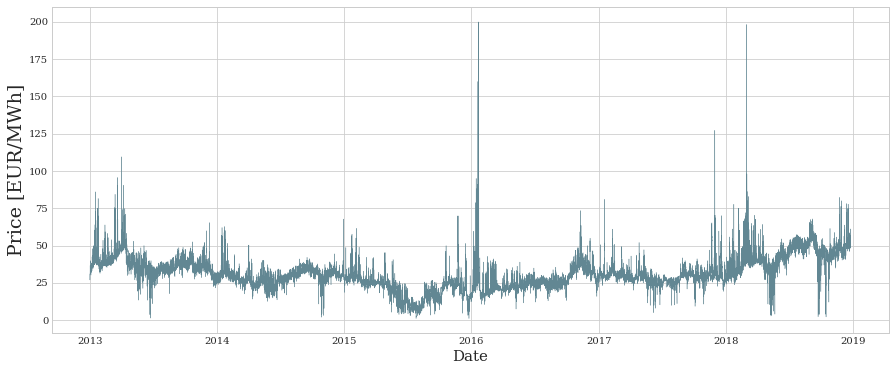

In [ ]:
import pandas as pd
from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.data.tsloader import TimeSeriesLoader

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 19

# Load and plot data
Y_df, X_df, S_df = EPF.load_groups(directory='./data', groups=['NP'])

fig = plt.figure(figsize=(15, 6))
plt.plot(Y_df.ds, Y_df.y.values, color='#628793', linewidth=0.4)
plt.ylabel('Price [EUR/MWh]', fontsize=19)
plt.xlabel('Date', fontsize=15)
# plt.savefig('./results/NP.png', bbox_inches = 'tight')
plt.show()

### Declare Model and Data Parameters

In [ ]:
# Architecture parameters
mc = {}
mc['model'] = 'nbeats'
mc['mode'] = 'simple'
mc['activation'] = 'SELU'

mc['input_size_multiplier'] = 1
mc['output_size'] = 24*7

# mc['input_size_multiplier'] = 7
# mc['output_size'] = 24

mc['stack_types'] = ['trend', 'seasonality', 'exogenous_wavenet']
mc['n_blocks'] = [1, 1, 1]
mc['n_layers'] = [2, 2, 2]
# mc['stack_types'] = ['trend', 'seasonality']
# mc['n_blocks'] = [1, 1]
# mc['n_layers'] = [2, 2]

mc['n_hidden'] = 128
mc['exogenous_n_channels'] = 8
mc['x_s_n_hidden'] = 0
mc['shared_weights'] = False
mc['n_harmonics'] = 4
mc['n_polynomials'] = 2

# Optimization and regularization parameters
mc['initialization'] = 'lecun_normal'
mc['learning_rate'] = 0.0007
mc['batch_size'] = 128
mc['lr_decay'] = 0.5
mc['n_lr_decay_steps'] = 2
mc['n_iterations'] = 20#_000
mc['early_stopping'] = 20
mc['eval_freq'] = 500
mc['batch_normalization'] = False
mc['dropout_prob_theta'] = 0.51
mc['dropout_prob_exogenous'] = 0.44
mc['l1_theta'] = 0
mc['weight_decay'] = 0
mc['loss'] = 'MAE'
mc['loss_hypar'] = 0.5
mc['val_loss'] = mc['loss']
mc['random_seed'] = 1

# Data Parameters
mc['len_sample_chunks'] = None
mc['idx_to_sample_freq'] = 1
mc['val_idx_to_sample_freq'] = 24 * 7
mc['n_val_weeks'] = 52
mc['window_sampling_limit'] = 500_000
mc['normalizer_y'] = None
mc['normalizer_x'] = 'median'
mc['complete_inputs'] = False
mc['frequency'] = 'H'
mc['seasonality'] = 24

# # Within decomposition
mc['learning_rate'] = 0.0005
mc['batch_size'] = 256
mc['weight_decay'] = 0.00006
mc['n_harmonics'] = 2
mc['n_polynomials'] = 4
mc['dropout_prob_theta'] = 0
mc['dropout_prob_exogenous'] = 0

print(65*'=')
print(pd.Series(mc))
print(65*'=')

mc['n_hidden'] = len(mc['stack_types']) * [ [int(mc['n_hidden']), int(mc['n_hidden'])] ]

model                                                      nbeats
mode                                                       simple
activation                                                   SELU
input_size_multiplier                                           1
output_size                                                   168
stack_types               [trend, seasonality, exogenous_wavenet]
n_blocks                                                [1, 1, 1]
n_layers                                                [2, 2, 2]
n_hidden                                                      128
exogenous_n_channels                                            8
x_s_n_hidden                                                    0
shared_weights                                              False
n_harmonics                                                     2
n_polynomials                                                   4
initialization                                       lecun_normal
learning_r

### Instantiate Loaders and Model

In [ ]:
from nixtla.experiments.utils import create_datasets

train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc,
                                                                     S_df=S_df, Y_df=Y_df, X_df=X_df,
                                                                     f_cols=['Exogenous1', 'Exogenous2'],
                                                                     ds_in_test=0,
                                                                     ds_in_val=728*24,
                                                                     n_uids=None, n_val_windows=None,freq=None, 
                                                                     is_val_random=False)

train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=int(mc['batch_size']),
                                shuffle=True)

val_loader = TimeSeriesLoader(dataset=val_dataset,
                              batch_size=int(mc['batch_size']),
                              shuffle=False)

mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

model = NBEATS(n_time_in=int(mc['input_size_multiplier'] * mc['output_size']),
               n_time_out=int(mc['output_size']),
               n_x=int(mc['n_x']),
               n_s=int(mc['n_s']),
               n_s_hidden=int(mc['x_s_n_hidden']),
               n_x_hidden=int(mc['exogenous_n_channels']),
               shared_weights=mc['shared_weights'],
               initialization=mc['initialization'],
               activation=mc['activation'],
               stack_types=mc['stack_types'],
               n_blocks=mc['n_blocks'],
               n_layers=mc['n_layers'],
               n_theta_hidden=mc['n_hidden'],
               n_harmonics=int(mc['n_harmonics']),
               n_polynomials=int(mc['n_polynomials']),
               batch_normalization = mc['batch_normalization'],
               dropout_prob_theta=mc['dropout_prob_theta'],
               learning_rate=float(mc['learning_rate']),
               lr_decay=float(mc['lr_decay']),
               n_lr_decay_steps=float(mc['n_lr_decay_steps']),
               weight_decay=mc['weight_decay'],
               n_iterations=int(mc['n_iterations']),
               early_stopping=int(mc['early_stopping']),
               loss=mc['loss'],
               loss_hypar=float(mc['loss_hypar']),
               val_loss=mc['val_loss'],
               frequency=mc['frequency'],
               seasonality=int(mc['seasonality']),
               random_seed=int(mc['random_seed']))

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2016-12-27 2018-12-24 23:00:00
          1           2013-01-01 2016-12-26 23:00:00
INFO:root:
Total data 			52416 time stamps 
Available percentage=100.0, 	52416 time stamps 
Insample  percentage=66.67, 	34944 time stamps 
Outsample percentage=33.33, 	17472 time stamps 

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2013-01-01 2016-12-26 23:00:00
          1           2016-12-27 2018-12-24 23:00:00
INFO:root:
Total data 			52416 time stamps 
Available percentage=100.0, 	52416 time stamps 
Insample  percentage=33.33, 	17472 time stamps 
Outsample percentage=66.67, 	34944 time stamps 

IN

### Train Model

In [ ]:
model.fit(train_ts_loader=train_loader, 
          val_ts_loader=val_loader,
          eval_freq=mc['eval_freq'])



============================== Start fitting ==============================
Step: 20, Time: 9.818, Insample MAE: 3.53937, Outsample MAE: 3.82907
==============================  End fitting  ==============================




### Make Predictions

In [ ]:
# Make predictions
Y_hat_df = model.forecast(mc=mc, S_df=S_df, Y_df=Y_df, X_df=X_df, f_cols=['Exogenous1', 'Exogenous2'], 
                          return_decomposition=True)

# if not ('exogenous_wavenet' in mc['stack_types']):
#     Y_hat_file = f'./results/{Y_df.unique_id[0]}_nbets_predictions.csv'
# else:
#     Y_hat_file = f'./results/{Y_df.unique_id[0]}_nbetsx_predictions.csv'    
# Y_hat_df.to_csv(Y_hat_file, index=False)

# Filter and rename
Y_hat_df = Y_hat_df.rename(columns={'y': 'True',
                                    'y_hat': 'Forecast',
                                    'level': 'Level', 
                                    'trend': 'Trend',
                                    'seasonality': 'Seasonality',
                                    'exogenous_wavenet': 'Exogenous',
                                    'residual': 'Residual'})

# Format date stamp
if mc['output_size']==24:
    Y_hat_df = Y_hat_df[(Y_hat_df.ds >= "2017-12-18") & (Y_hat_df.ds < "2017-12-19")]
    x_plot = Y_hat_df.ds.values
    #x_plot_min = str(Y_hat_df.ds.min())[:16]
    #x_plot_max = str(Y_hat_df['ds'].max())[:16]
    x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y, %R')
    x_plot_max = pd.to_datetime(x_plot.max()).strftime('%R')
    Y_hat_df['ds'] = Y_hat_df.ds.dt.hour.values

if mc['output_size']>24:
    Y_hat_df = Y_hat_df[(Y_hat_df.ds >= "2013-05-28") & (Y_hat_df.ds < "2013-06-04")]
    x_plot = Y_hat_df.ds.values
    x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y')
    x_plot_max = pd.to_datetime(x_plot.max()).strftime('%B %d, %Y')
    Y_hat_df['ds'] = np.arange(1,169)
    
# If not exogenous fill with nan (plot purposes)
if 'Exogenous' not in Y_hat_df.columns:
    exog = np.empty(len(Y_hat_df))
    exog[:] = np.nan
    Y_hat_df['Exogenous'] = exog
    
Y_hat_df

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        1           2013-01-01 2018-12-24 23:00:00
INFO:root:
Total data 			52416 time stamps 
Available percentage=100.0, 	52416 time stamps 
Insample  percentage=100.0, 	52416 time stamps 
Outsample percentage=0.0, 	0 time stamps 

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2013-01-01 2018-12-24 23:00:00
INFO:root:
Total data 			52416 time stamps 
Available percentage=100.0, 	52416 time stamps 
Insample  percentage=0.0, 	0 time stamps 
Outsample percentage=100.0, 	52416 time stamps 

INFO:root:Train Validation splits

INFO:root:                              ds                    
                      

,unique_id,ds,True,Forecast,Level,Trend,Seasonality,Exogenous,Residual
3360,NP,1,35.63,40.237461,38.330002,0.421608,1.459525,0.026326,-4.607461
3361,NP,2,33.18,39.896782,38.330002,0.419676,1.121736,0.025370,-6.716782
3362,NP,3,32.08,36.668678,38.330002,0.417653,-2.102918,0.023940,-4.588678
3363,NP,4,30.69,38.836323,38.330002,0.415543,0.067806,0.022973,-8.146323
3364,NP,5,31.47,37.961559,38.330002,0.413345,-0.804523,0.022735,-6.491559
...,...,...,...,...,...,...,...,...,...
3523,NP,164,38.68,39.506351,38.330002,-0.971774,2.130912,0.017211,-0.826351
3524,NP,165,38.38,39.012104,38.330002,-0.992383,1.654880,0.019603,-0.632104
3525,NP,166,38.31,38.852314,38.330002,-1.013282,1.521974,0.013622,-0.542314
3526,NP,167,37.89,35.393654,38.330002,-1.034474,-1.912737,0.010860,2.496346


Hours [May 28, 2013 to June 03, 2013]


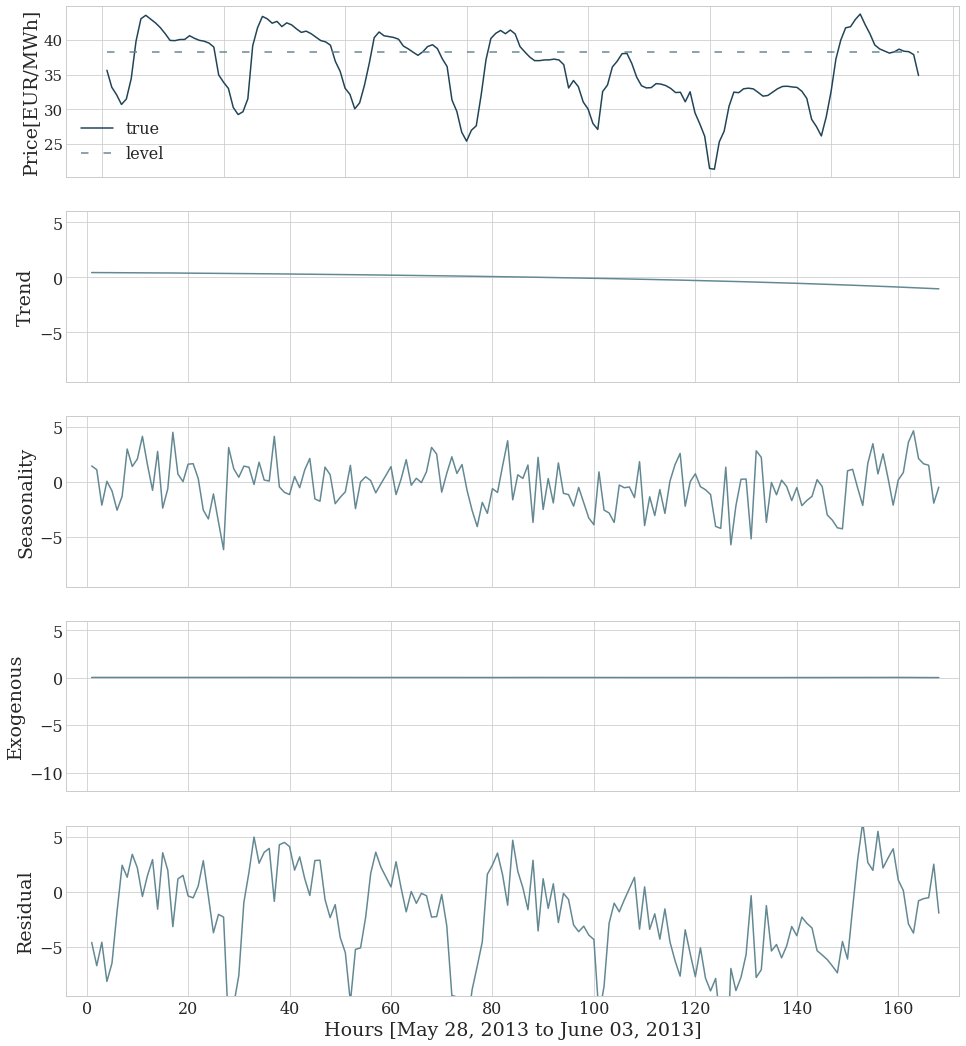

In [ ]:
# Plot Decomposition
x_axis_str = f'Hours [{x_plot_min} to {x_plot_max}]'
print(x_axis_str)

fig = plt.figure(figsize=(16, 12.5))
if mc['output_size']==24: fig = plt.figure(figsize=(8, 12.5))
ax0 = plt.subplot2grid((5,1),(0, 0))
ax1 = plt.subplot2grid((5,1),(1, 0))
ax2 = plt.subplot2grid((5,1),(2, 0), sharey=ax1)
#ax3 = plt.subplot2grid((5,1),(3, 0), sharey=ax1)
ax3 = plt.subplot2grid((5,1),(3, 0))
ax4 = plt.subplot2grid((5,1),(4, 0), sharey=ax1)
# ax2 = plt.subplot2grid((5,1),(2, 0))
# ax3 = plt.subplot2grid((5,1),(3, 0))
# ax4 = plt.subplot2grid((5,1),(4, 0))

axs = [ax0, ax1, ax2, ax3, ax4]

axs[0].plot(Y_hat_df['ds'], Y_hat_df['True'], c='#204457', label='true')
axs[0].plot(Y_hat_df['ds'], Y_hat_df['Level'], c='#628893', label='level',
            linestyle=(0,(5,10)))
#axs[0].plot(Y_hat_df['ds'], Y_hat_df['Forecast'], c='peru', label='forecast', 
#            linestyle='dashdot')
axs[0].set_ylabel('Price[EUR/MWh]', fontsize=FONTSIZE)
axs[0].yaxis.set_tick_params(labelsize=FONTSIZE-4)
axs[0].set_xticklabels([])

for i, comp in enumerate(['Trend', 'Seasonality', 'Exogenous', 'Residual']):
    axs[i+1].plot(Y_hat_df['ds'], Y_hat_df[comp], c='#628893')
    axs[i+1].set_ylabel(comp, fontsize=FONTSIZE)
    axs[i+1].yaxis.set_tick_params(labelsize=FONTSIZE-3)
    axs[i+1].xaxis.set_tick_params(labelsize=FONTSIZE-3)
    axs[i+1].set_xlim(-4, 172)
        
    if i<3:
        axs[i+1].set_xticklabels([])

    if np.sum(np.isnan(Y_hat_df[comp]))==len(Y_hat_df[comp]):
        axs[i+1].set_visible(False)
        
    if not (i == 2):
        axs[i+1].set_ylim(-9.5, 6)

    if not (i == 3):
        axs[i+1].set_ylim(-12, 6)
        
#     # Trend
#     if i==0:
#         #axs[i+1].set_ylim(-1, 4)
#         axs[i+1].set_ylim(-0.5, 1)
    
#     # Seasonality
#     if i==1:
#         #axs[i+1].set_ylim(-4, 7)
#         axs[i+1].set_ylim(-12, 7)
    
#     # Exogenous
#     if i==2:
#         #axs[i+1].set_ylim(-6, 25)
#         axs[i+1].set_ylim(-12, 7)
            
#     # Residual
#     if i==3:
#         #axs[i+1].set_ylim(-6, 25)
#         axs[i+1].set_ylim(-7, 7)

axs[0].legend(prop={'size': FONTSIZE-3})
axs[4].set_xlabel(x_axis_str, fontsize=FONTSIZE)
# axs[4].set_xticks(range(1,169))


plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, 
                    top=1.2, wspace=0.2, hspace=0.2)
plt.savefig('./results/variance_decomposition.pdf', bbox_inches = 'tight')
plt.show()